<a href="https://colab.research.google.com/github/yotamgardosh/Face-Landmark-Recognition/blob/main/FaceLandMark_NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import torchvision.transforms.functional as TF
import torch
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
import imutils
from math import *

import time
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

load dataset

In [2]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

visualize data

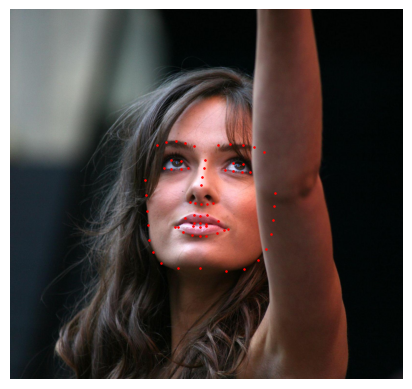

In [3]:
image_path = '/content/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'
landmark_path = '/content/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts'

def load_landmarks(file_path):
    with open(file_path, 'r') as f:
        landmarks = []
        for line in f.readlines()[3:-1]:
            x, y = map(float, line.strip().split())
            landmarks.append((x, y))
    return np.array(landmarks)

landmarks = load_landmarks(landmark_path)

def visualize_image_with_landmarks(image_path, landmarks):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)

    # Plot the landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', marker='.', s=3)

    # Show plot
    plt.axis('off')
    plt.show()

visualize_image_with_landmarks(image_path, landmarks)



create image transformer class

In [4]:
class ImageTransformer:
    def __init__(self, rotation_range=10, resize_dim=(244,244), translation_range=0.1):
        self.rotation_range = rotation_range
        self.resize_dim = resize_dim
        self.translation_range = translation_range
        self.kernal_options = [1,3,5]

    def random_rotation(self, image, landmarks):
        angle = random.uniform(-self.rotation_range, +self.rotation_range)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks


    def uniform_resize(self, image, landmarks):

        # Resize the image using torchvision's functional interface
        resized_image = TF.resize(image, self.resize_dim)

        return resized_image, landmarks


    def random_color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks


    def gaussin_blur(self, image, landmarks):
        # Randomly sample a kernel size within the defined range
        kernel_size = self.kernal_options[random.randint(0,2)]

        # Apply Gaussian blur to the image
        blurred_image = TF.gaussian_blur(image, kernel_size)

        # Return the blurred image and landmarks (unchanged)
        return blurred_image, landmarks



    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks


    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.uniform_resize(image, landmarks)
        image, landmarks = self.random_color_jitter(image, landmarks)
        image, landmarks = self.random_rotation(image, landmarks)
        image, landmarks = self.gaussin_blur(image, landmarks)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        landmarks -= 0.5

        return image, landmarks








In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        return image, landmarks

dataset = FaceLandmarksDataset(ImageTransformer())

Visualize train Transform

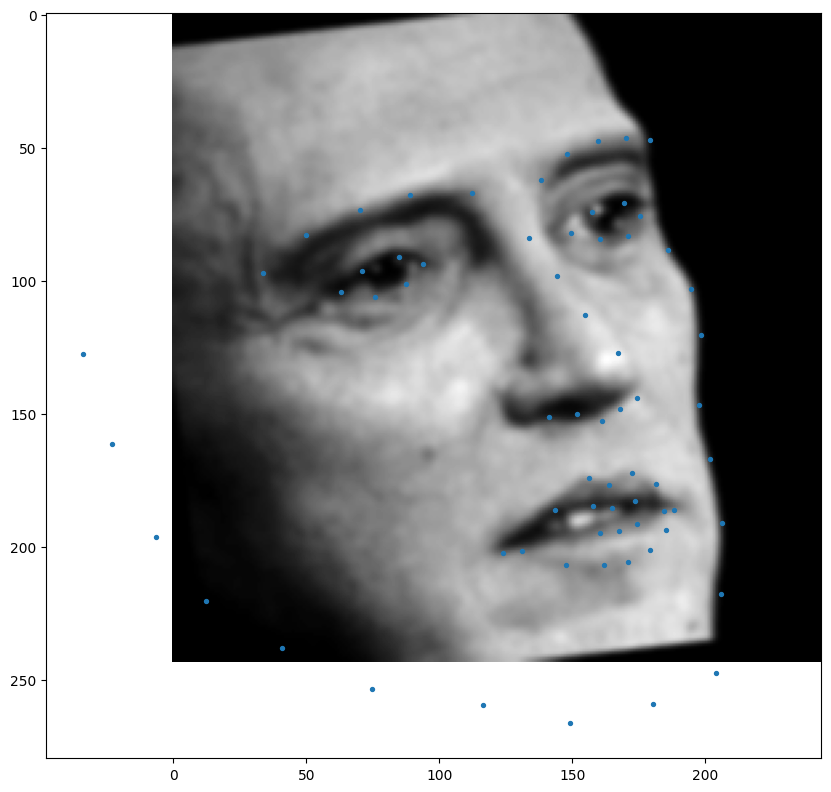

In [6]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 244
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray'); # Convert image tensor to numpy array
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);


defining the *model*

In [7]:
def train_valid_split(dataset):
    valid_len = int(0.1 * len(dataset))
    train_len = len(dataset) - valid_len

    print("the length of the train data is {}".format(train_len))
    print("the length of the validation data is {}".format(valid_len))

    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_len, valid_len])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
    return train_loader, valid_loader

In [8]:
class NeuralNetwork(nn.Module):
    """
    A neural network model for predicting facial landmarks using a modified ResNet-18 architecture.

    Attributes:
    -----------
    model_name : str
        The name of the model architecture being used.
    model : torchvision.models.ResNet
        The ResNet-18 model with modified layers for single-channel input and a custom output layer.
    """
    def __init__(self, num_of_classes=136):
        """
        Initializes the NeuralNetwork with a modified ResNet-18 architecture.

        Parameters:
        -----------
        num_of_classes : int, optional
            The number of output classes. Defaults to 136, which corresponds to the x and y coordinates of 68 landmarks.
        """
        super().__init__()
        self.model_name = 'resnet18'
        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_of_classes)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        -----------
        x : torch.Tensor
            The input tensor, typically a batch of images.

        Returns:
        --------
        torch.Tensor
            The output tensor, which contains the predicted coordinates of the facial landmarks.
        """
        x = self.model(x)
        return x


In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (images, landmarks) in enumerate(train_loader):
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)
        loss = criterion(outputs, landmarks)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()
        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f'Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    with torch.no_grad():
        for i, (images, landmarks) in enumerate(val_loader):
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device)

            outputs = model(images)
            loss = criterion(outputs, landmarks)
            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    return epoch_loss


In [10]:
def train_and_validate_model(dataset):
    # Hyperparameters
    num_epochs = 5
    learning_rate = 0.001

    # Initialize the model, loss function, optimizer and loaders
    model = NeuralNetwork(num_of_classes=136)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_loader, valid_loader = train_valid_split(dataset)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_path = 'best_face_landmark_model.pth'

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
      train_loss = train(model, train_loader, criterion, optimizer, device)
      val_loss = validate(model, valid_loader, criterion, device)

      train_losses.append(train_loss)
      val_losses.append(val_loss)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

      # Save the model if the validation loss is the best we've seen so far
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), best_model_path)
          print(f'Saving the best model with validation loss: {best_val_loss:.4f}')

    # Plot the training and validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



the length of the train data is 6000
the length of the validation data is 666
Batch [10/94], Loss: 0.0216
Batch [20/94], Loss: 0.0089
Batch [30/94], Loss: 0.0066
Batch [40/94], Loss: 0.0060
Batch [50/94], Loss: 0.0057
Batch [60/94], Loss: 0.0059
Batch [70/94], Loss: 0.0056
Batch [80/94], Loss: 0.0055
Batch [90/94], Loss: 0.0064
Epoch [1/5], Train Loss: 0.0177, Validation Loss: 0.0056
Saving the best model with validation loss: 0.0056
Batch [10/94], Loss: 0.0058
Batch [20/94], Loss: 0.0057
Batch [30/94], Loss: 0.0058
Batch [40/94], Loss: 0.0056
Batch [50/94], Loss: 0.0058
Batch [60/94], Loss: 0.0053
Batch [70/94], Loss: 0.0061
Batch [80/94], Loss: 0.0054
Batch [90/94], Loss: 0.0051
Epoch [2/5], Train Loss: 0.0055, Validation Loss: 0.0055
Saving the best model with validation loss: 0.0055
Batch [10/94], Loss: 0.0044
Batch [20/94], Loss: 0.0053
Batch [30/94], Loss: 0.0051
Batch [40/94], Loss: 0.0058
Batch [50/94], Loss: 0.0049
Batch [60/94], Loss: 0.0049
Batch [70/94], Loss: 0.0055
Batch 

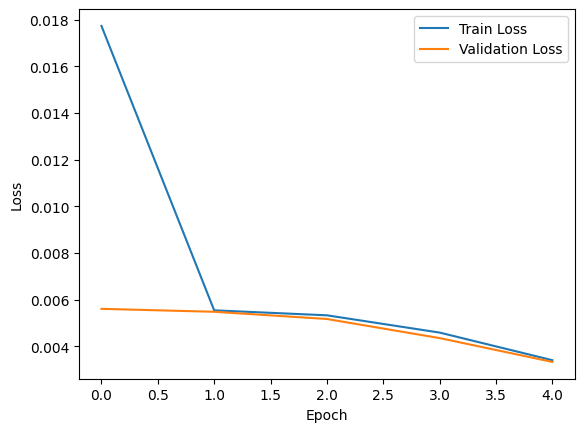

In [13]:
train_and_validate_model(dataset)

In [18]:
def show_exmaples(dataset):
    with torch.no_grad():

      best_model = NeuralNetwork()
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      best_model.to(device)
      best_model.load_state_dict(torch.load('/content/best_face_landmark_model.pth'))
      best_model.eval()

      _, valid_loader = train_valid_split(dataset)
      images, landmarks = next(iter(valid_loader))

      # images = images.cuda()
      landmarks = (landmarks + 0.5) * 244


      predictions = (best_model(images).to(device) + 0.5) * 244
      predictions = predictions.view(-1,68,2)

      plt.figure(figsize=(10,40))

      for img_num in range(8):
          plt.subplot(8,1,img_num+1)
          plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
          plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
          plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)


the length of the train data is 6000
the length of the validation data is 666


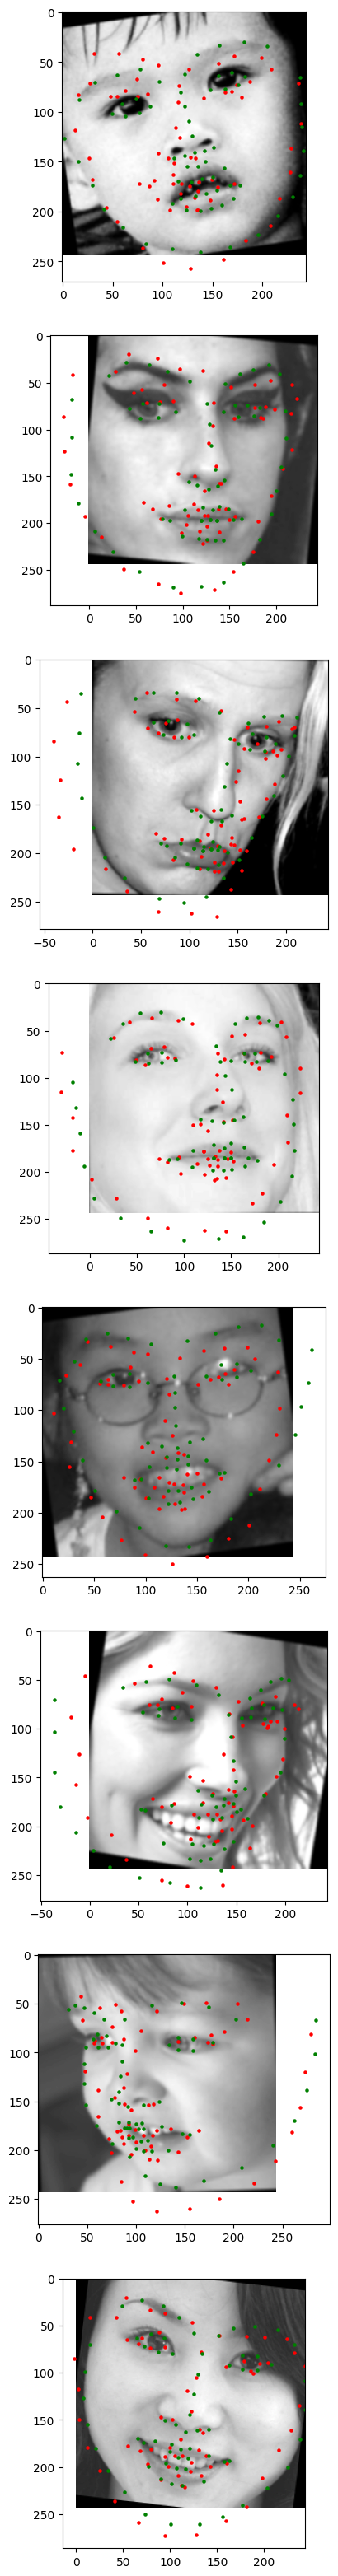

In [19]:
show_exmaples(dataset)